In [75]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle as pkl
import sys

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

import torch.utils.data as data 
import torch
from torch_geometric.data import Data
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch.utils.data import Dataset, DataLoader

import os
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.loader import NeighborLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.nn import MessagePassing, SAGEConv
from ogb.nodeproppred import Evaluator #PygNodePropPredDatase

from IPython.display import clear_output


from sklearn import preprocessing

import torch
import torch.nn as nn
import torch.nn.functional as F



In [76]:
# Read files
path = "C:/Users/gsamp/OneDrive/Documents/AI-3/2n Semestre/Projecte de Síntesi 2/GraphAnomaly/dades_guillem/"
df_train_init = pd.read_csv(path + "train_set.csv") 
df_test_init = pd.read_csv(path + "test_set.csv")

In [77]:
path = "C:/Users/gsamp/OneDrive/Documents/AI-3/2n Semestre/Projecte de Síntesi 2/GraphAnomaly/dades_guillem/"
df_classes = pd.read_csv(path + "elliptic_txs_classes.csv") # Nodes' labels
df_edges_init = pd.read_csv(path + "elliptic_txs_edgelist.csv") # Edges
df_features = pd.read_csv(path + "elliptic_txs_features.csv", header=None) # Nodes' features

# Change column names of df_features
colNames1 = {'0': 'txId', 1: "Time step"}
colNames2 = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(93)}
colNames3 = {str(ii+95): "Aggregate_feature_" + str(ii+1) for ii in range(72)}

colNames = dict(colNames1, **colNames2, **colNames3 )
colNames = {int(jj): item_kk for jj,item_kk in colNames.items()}

df_features = df_features.rename(columns=colNames)

In [78]:
def prep_df(feats: pd.DataFrame, edges: pd.DataFrame):
    #1 és la classe illicit, 2 la  licit
    df_feats = feats.loc[feats['class'].isin([1, 2])]
    df_feats['class'] = df_feats['class'].replace({1: 0, 2: 1})
    df_feats = df_feats.reset_index(drop=True)

    #ens quedem només amb els edges que apareixen en el nodes d'entrenament
    df_edges = edges.loc[((edges['txId1'].isin(df_feats['txId'])) & (df_edges_init['txId2'].isin(df_feats['txId'])))]
    df_edges = df_edges.reset_index(drop=True)
    print(f"contador de valors per classe: \n {df_feats['class'].value_counts()}\n")
    return  df_feats, df_edges

df_train, df_edges_train = prep_df(df_train_init, df_edges_init)
df_test, df_edges_test = prep_df(df_test_init, df_edges_init)

contador de valors per classe: 
 class
1    34654
0     2672
Name: count, dtype: int64

contador de valors per classe: 
 class
1    7365
0    1873
Name: count, dtype: int64



C:\Users\gsamp\AppData\Local\Temp\ipykernel_6624\1761167425.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feats['class'] = df_feats['class'].replace({1: 0, 2: 1})


In [79]:
def map_idx(feats: pd.DataFrame, edges: pd.DataFrame, save = True, loading_dir = "a"):
    mapping_txid = dict(zip(feats['txId'], list(feats.index)))
    dir = 'dades_guillem/' + str(loading_dir) + '.pkl'
    if save:
        df_edges_mapped = edges.replace({'txId1': mapping_txid, 'txId2': mapping_txid})
        
        df_edges_mapped.to_pickle(loading_dir)
    else:
        df_edges_mapped = pd.read_pickle(loading_dir)
    return df_edges_mapped

df_edges_mapped_train = map_idx(feats = df_train, edges = df_edges_train, save = True, loading_dir='train')
df_edges_mapped_test = map_idx(feats = df_test, edges = df_edges_test, save = True, loading_dir='train')


In [80]:
def get_data(feats: pd.DataFrame, edges:pd.DataFrame):
    x = torch.tensor(feats.drop(columns=['class', 'Time Step', 'txId']).values, dtype=torch.float)
    edge_index = torch.tensor(edges.values, dtype=torch.long).T
    y = torch.tensor(feats['class'].values)
    time = torch.tensor(feats['Time Step'].values)
    data = Data(x=x, edge_index=edge_index, y=y, time=time)
    return data


train_data = get_data(df_train, df_edges_mapped_train)
test_data = get_data(df_test, df_edges_mapped_test)

Prepare data for the AE case

In [81]:
#separate illicit and licit data
def separate_data(feats):
    licit_x = torch.tensor(feats.loc[feats['class'] == 1].drop(columns=['class', 'Time Step']).values, dtype=torch.float)
    licit_y = torch.tensor(feats.loc[feats['class'] == 1]['class'].values)
    licit_data = Data(x=licit_x, y=licit_y)

    illicit_x = torch.tensor(feats.loc[feats['class'] == 0].drop(columns=['class', 'Time Step']).values, dtype=torch.float)
    illicit_y = torch.tensor(feats.loc[feats['class'] == 0]['class'].values)
    illicit_data = Data(x=illicit_x, y=illicit_x)
    return licit_data, illicit_data

train_licit, train_illicit = separate_data(df_train)
test_licit, test_illicit = separate_data(df_test)    

In [82]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.tensor(sample, dtype=torch.float32), torch.tensor(sample, dtype=torch.float32)

In [83]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=50):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.Tanh(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 100),
            nn.Tanh(),
            nn.Linear(100, input_dim),
            nn.ReLU()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [84]:
def train_ae(autoencoder, data_loader, criterion, optimizer, val_loader, num_epochs=10, learning_rate=0.001):   
    total_train_loss = [] 
    total_validation_loss = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in data_loader:
            optimizer.zero_grad()
            
            # Forward pass
            outputs = autoencoder(inputs)
            
            # Compute the loss
            loss = criterion(outputs, targets)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        train_loss = running_loss / len(data_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}")
        total_train_loss.append(train_loss)
        
        #validació dins del mateix train loop
        validation_loss = val_ae(autoencoder=autoencoder, data_loader=val_loader, criterion=criterion)
        print(f"Validation Loss: {validation_loss:.4f}")
        total_validation_loss.append(validation_loss)
    return total_train_loss, total_validation_loss

def val_ae(autoencoder, data_loader, criterion):
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = autoencoder(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    epoch_loss = val_loss / len(data_loader.dataset)
    return epoch_loss


In [85]:
batch_size = 128

#samplejar només n elements de les lícites per entrenar el AE
x = torch.tensor(df_train.loc[df_train["class"] == 1].drop(columns=['class', 'txId', 'Time Step']).values)

n = int(x.shape[0] * 0.2)
x_train = x[n:]
x_val = x[:n]
print(x_train.shape)
#amb el scaler la loss passe de 4 a 0.1
train_data = preprocessing.MinMaxScaler().fit_transform(x_train)
val_data = preprocessing.MinMaxScaler().fit_transform(x_val)

# train_data, val_data = train_test_split(x, test_size=0.2, random_state=42)

train_dataset = CustomDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = CustomDataset(val_data)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

#hiperparàmetres
lr = 0.001
EPOCHS = 200

input_dim = x_train.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)



training_loss, validation_loss = train_ae(autoencoder=model, data_loader=train_loader, criterion=criterion, optimizer=optimizer, val_loader=val_loader, num_epochs=EPOCHS, learning_rate=lr)
torch.save(model.state_dict(), 'C:/Users/gsamp/OneDrive/Documents/AI-3/2n Semestre/Projecte de Síntesi 2/GraphAnomaly/GNN_models/trained_models/ae_250_lower_batch.pth')

torch.Size([27724, 165])
Epoch [1/200], Training Loss: 0.1464
Validation Loss: 0.1523
Epoch [2/200], Training Loss: 0.1456
Validation Loss: 0.1515
Epoch [3/200], Training Loss: 0.1447
Validation Loss: 0.1506
Epoch [4/200], Training Loss: 0.1438
Validation Loss: 0.1496
Epoch [5/200], Training Loss: 0.1429
Validation Loss: 0.1487
Epoch [6/200], Training Loss: 0.1420
Validation Loss: 0.1478
Epoch [7/200], Training Loss: 0.1411
Validation Loss: 0.1469
Epoch [8/200], Training Loss: 0.1402
Validation Loss: 0.1459
Epoch [9/200], Training Loss: 0.1393
Validation Loss: 0.1450
Epoch [10/200], Training Loss: 0.1384
Validation Loss: 0.1441
Epoch [11/200], Training Loss: 0.1375
Validation Loss: 0.1432
Epoch [12/200], Training Loss: 0.1366
Validation Loss: 0.1422
Epoch [13/200], Training Loss: 0.1357
Validation Loss: 0.1413
Epoch [14/200], Training Loss: 0.1348
Validation Loss: 0.1404
Epoch [15/200], Training Loss: 0.1339
Validation Loss: 0.1395
Epoch [16/200], Training Loss: 0.1330
Validation Loss:

Error de recunstrucció

In [98]:
# Define the path to the saved model
model_path = """C:/Users/gsamp/OneDrive/Documents/AI-3/2n Semestre/Projecte de Síntesi 2/GraphAnomaly/GNN_models/trained_models/ae_250_lower_batch.pth"""

# Create an instance of your model
model = Autoencoder(input_dim)

# Load the state_dict into the model
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()

# Initialize variables for storing reconstruction error


ilicit_data = torch.tensor(df_train.loc[df_train["class"] == 0].drop(columns=['class', 'txId', 'Time Step']).values)

ilicit_data = preprocessing.MinMaxScaler().fit_transform(ilicit_data)


ilicit_dataset = CustomDataset(ilicit_data)
ilicit_loader = DataLoader(ilicit_dataset, batch_size=batch_size, shuffle=True)


# Assuming you have already defined the necessary modules and datasets

# Initialize variables for storing reconstruction error
total_licit_loss = 0
total_ilicit_loss = 0
num_batches = 0

licit_loss_history = []
ilicit_loss_history = []

# Iterate through the validation dataset
with torch.no_grad():
    for seen, unseen in zip(val_loader, ilicit_loader):
        
        seen_inputs, _ = seen
        unseen_inputs, _ = unseen
        
        seen_outputs = model(seen_inputs)
        unseen_outputs = model(unseen_inputs)
        
        seen_loss = criterion(seen_outputs, seen_inputs)  # Compute reconstruction loss
        unseen_loss = criterion(unseen_outputs, unseen_inputs)
        
        licit_loss_history.append(float(seen_loss))
        ilicit_loss_history.append(float(unseen_loss))
        
        total_licit_loss += seen_loss.item()
        total_ilicit_loss += unseen_loss.item()
        num_batches += 1

# Compute average reconstruction error for both seen and unseen classes
average_licit_loss = total_licit_loss / num_batches
average_ilicit_loss = total_ilicit_loss / num_batches

print("Average Reconstruction Error for Licit Class:", average_licit_loss)
print("Average Reconstruction Error for Illicit Class:", average_ilicit_loss)

# You can return ilicit_loss_history if you want to analyze it further


Average Reconstruction Error for Licit Class: 0.08254859880322502
Average Reconstruction Error for Illicit Class: 0.06398672096076466


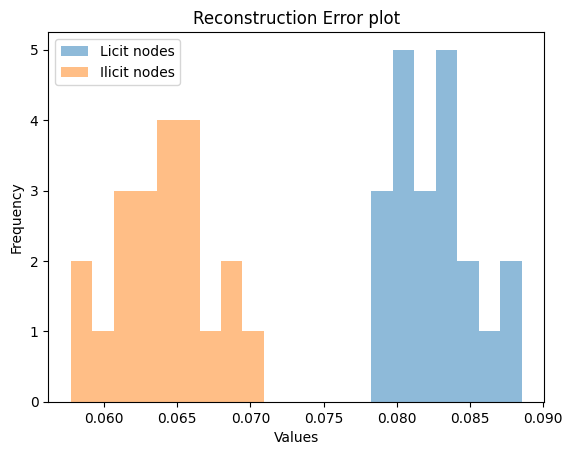

In [99]:
import matplotlib.pyplot as plt

# Determine the range of values in both lists
min_value = min(min(licit_loss_history), min(ilicit_loss_history))
max_value = max(max(licit_loss_history), max(ilicit_loss_history))

# Plot histograms for both lists with 10 bins
plt.hist(licit_loss_history, bins=len(licit_loss_history), alpha=0.5, label='Licit nodes', range=(min_value, max_value))
plt.hist(ilicit_loss_history, bins=len(ilicit_loss_history), alpha=0.5, label='Ilicit nodes', range=(min_value, max_value))

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Reconstruction Error plot')

# Add legend
plt.legend()

# Show the plot
plt.show()


Classificar l'espai embedded